In [1]:
#!pip install ydata-profiling demoji nltk scikit-learn gensim pyLDAvis textblob spacy textstat transformers torch xgboost shap

In [2]:
import requests, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from ydata_profiling import ProfileReport
from textstat import flesch_reading_ease  # exploring text complixity
import nltk
from nltk.tokenize import word_tokenize
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# classification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, AdamW

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Program Files\Python311\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Program Files\Python311\Lib\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nb.jit


In [3]:
diplomacy= pd.read_json('data/all_data.jsonl', lines=True)
diplomacy.head(2)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1


In [4]:
token = '[SEP]' # the seperator token for BERT
conversations = []

for i, j in diplomacy.iterrows(): 
    players = j['players']
    if(len(j['messages']) == 0):
        print("Empty Row: " , i)
        continue
    message = '[CLS]'
    for c, d in enumerate(j['messages']):       
        if (j['speakers'][c] == players[0]):
            message += 'A:' + j['messages'][c] + token
        if (j['speakers'][c] == players[1]):    
             message += 'B:' + j['messages'][c] + token
                
    conversations.append(message)

df1 = pd.DataFrame({'conversation': conversations, 'A_bad_intent': 1 , 'B_bad_intent': 1})                     
df1.info()

Empty Row:  9
Empty Row:  62
Empty Row:  87
Empty Row:  96
Empty Row:  188
Empty Row:  249
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   conversation  246 non-null    object
 1   A_bad_intent  246 non-null    int64 
 2   B_bad_intent  246 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 5.9+ KB


In [5]:
df1.loc[0]['conversation']

'[CLS]A:Germany!\n\nJust the person I want to speak with. I have a somewhat crazy idea that I’ve always wanted to try with I/G, but I’ve never actually convinced the other guy to try it. And, what’s worse, it might make you suspicious of me. \n\nSo...do I suggest it?\n\nI’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? That’s my hope anyway.\n\nWhat is your appetite like for unusual and crazy?[SEP]B:You\'ve whet my appetite, Italy. What\'s the suggestion?[SEP]A:👍[SEP]B:It seems like there are a lot of ways that could go wrong...I don\'t see why France would see you approaching/taking Munich--while I do nothing about it--and not immediately feel skittish[SEP]A:Yeah, I can’t say I’ve tried it and it works, cause I’ve never tried it or seen it. But how I think it would work is (a) my Spring move looks like an attack on Austria, so it would not be surprising if you did not cover Munich. Then (b) you bu

In [6]:
good = pd.read_csv('data/full_dialog.csv')
good.head()

,Unnamed: 0,Unit,Turn,B4,B2
0,0,Good morning. How are you doing today?,0,0,20180904-045349_715_live
1,1,Hi. I am doing good. How about you?,0,1,20180904-045349_715_live
2,2,I'm doing pretty good for a Tuesday morning.,1,0,20180904-045349_715_live
3,3,"Haha. Same here, but it really feels like a Mo...",1,1,20180904-045349_715_live
4,4,Ugh yes it does!,2,0,20180904-045349_715_live


In [7]:
conversations = []
n =0

for i, j in good.iterrows(): 
    
    # This is a new conversation, append the prevoius conversation to the conversations list
    if j['Turn'] == 0 and n == 2 :
        conversations.append(conv)
        n=0
    # its the sencond turn=0 of each conversation
    if j['Turn'] == 0 and n == 1 :
        n =2
    # if its start of a new conversation including the very first one
    if j['Turn'] == 0 and n == 0 :
        conv = '[CLS]'
        # becouse there are two messages with turn=0 in each convrsation
        n =1
    if(j['B4'] == 0) :
        conv+= 'A:' + j['Unit'] + '[SEP]'
    elif (j['B4'] == 1):
        conv+= 'B:' + j['Unit'] + '[SEP]'  
      
df2 = pd.DataFrame({'conversation': conversations, 'A_bad_intent': 0, 'B_bad_intent': 0})                     
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   conversation  1016 non-null   object
 1   A_bad_intent  1016 non-null   int64 
 2   B_bad_intent  1016 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.9+ KB


In [8]:
df2.loc[0]['conversation']

"[CLS]A:Good morning. How are you doing today?[SEP]B:Hi. I am doing good. How about you?[SEP]A:I'm doing pretty good for a Tuesday morning. [SEP]B:Haha. Same here, but it really feels like a Monday.[SEP]A:Ugh yes it does![SEP]B:I can not believe how warm it is already.[SEP]A:Where are you from? [SEP]B:I am from the Midwest. What about you?[SEP]A:I'm from the South East. It's always warm here. [SEP]B:Oh, yep. You are definitely in for warm weather, which is great as far as I am concerned.[SEP]A:We're about to get hit by a tropical storm.[SEP]B:I heard that some bad weather was going to be coming. I hope it is not too severe.[SEP]A:Me too. It's just part of living on the Gulf. You have to be prepared for it.[SEP]B:Yes, I am sure you get a lot of storms.[SEP]A:We do. I guess I should get into what this chat is supposed to be about. Have you heard of the Charity Save The Children?[SEP]B:I have heard about them. What do you like about them?[SEP]A:I like that they're committed to helping chi

In [9]:
df = pd.concat([df1, df2], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   conversation  1262 non-null   object
 1   A_bad_intent  1262 non-null   int64 
 2   B_bad_intent  1262 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 29.7+ KB


In [10]:
df

,conversation,A_bad_intent,B_bad_intent
0,[CLS]A:Germany!\n\nJust the person I want to s...,1,1
1,[CLS]B:Hello there! What's your general plan f...,1,1
2,[CLS]B:Buongiorno! \nBe kinda nice to know if ...,1,1
3,[CLS]B:Hey italy! good luck this game. I'm gue...,1,1
4,[CLS]B:Hello Italy what’s up what are your tho...,1,1
...,...,...,...
1257,"[CLS]A:Good morning, how are you doing today?[...",0,0
1258,[CLS]A:hi[SEP]B:Hi how are you?[SEP]A:i'm fine...,0,0
1259,"[CLS]A:hi[SEP]B:Hello, how are you?[SEP]A:i am...",0,0
1260,[CLS]A:Hi there! How are you today?[SEP]B:I am...,0,0


---
### Preprocessing the combined dataset

In [11]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
df[df['conversation'] == '']

,conversation,A_bad_intent,B_bad_intent


In [13]:
def text_preprocess(message):
    processed = []   
    for text in message:
        # replaace URLs
        text = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",' <URL>',text)        
        # Remove HTML/XML tags (if any)
        text = re.sub(r'<.*?>', '', text)
        # Remove punctuation and symbols (not for now)
        # text = re.sub(r'[^\w\s]', '', text) 
        # Remove numbers - not in this dataset!
        #text = re.sub(r'\d+', '', text)
        # Remove whitespaces (including new lines and tabs)
        text = text.strip().replace("\n", " ").replace("\r", " ").replace("\t", " ")
        
        processed.append(text)       
    return processed

In [14]:
df['conversation'] = text_preprocess(list(df['conversation']))
df

,conversation,A_bad_intent,B_bad_intent
0,[CLS]A:Germany! Just the person I want to spe...,1,1
1,[CLS]B:Hello there! What's your general plan f...,1,1
2,[CLS]B:Buongiorno! Be kinda nice to know if y...,1,1
3,[CLS]B:Hey italy! good luck this game. I'm gue...,1,1
4,[CLS]B:Hello Italy what’s up what are your tho...,1,1
...,...,...,...
1257,"[CLS]A:Good morning, how are you doing today?[...",0,0
1258,[CLS]A:hi[SEP]B:Hi how are you?[SEP]A:i'm fine...,0,0
1259,"[CLS]A:hi[SEP]B:Hello, how are you?[SEP]A:i am...",0,0
1260,[CLS]A:Hi there! How are you today?[SEP]B:I am...,0,0


<Axes: >

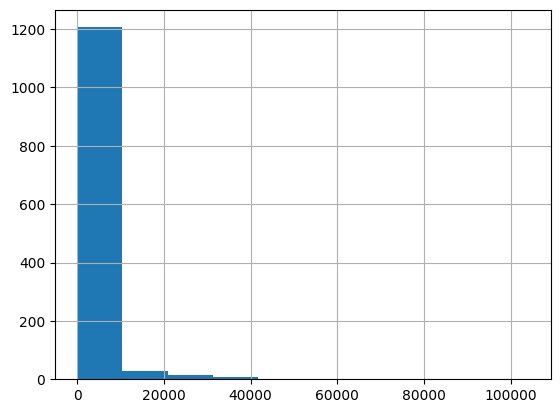

In [15]:
#number of characters in each conversation
df['conversation'].str.len().hist()

<Axes: >

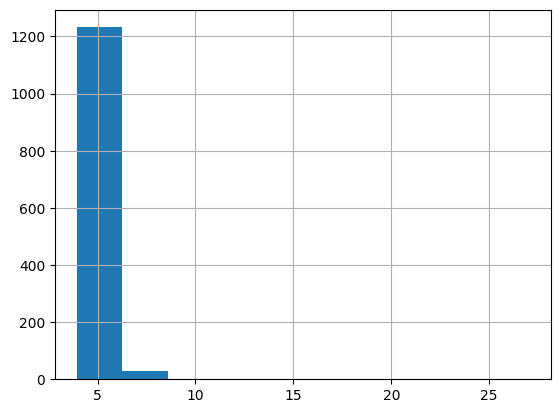

In [16]:
#  check the average word length
df['conversation'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()  

<Axes: >

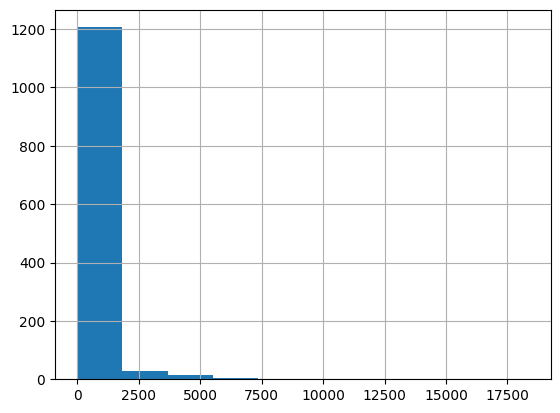

In [17]:
#  check the number of words in each message list
df['conversation'].str.split().apply(lambda x : len(x)).hist()  

In [18]:
# number of conversation wth more than 512 words
long_conversations = sum([1 if len(i.split()) > 512 else 0 for i in df['conversation']])
long_conversations

232

In [19]:
df['conversation'].str.split().apply(lambda x : len(x)).describe()

count     1262.000000
mean       529.881141
std       1017.760600
min          1.000000
25%        229.000000
50%        319.000000
75%        446.750000
max      18352.000000
Name: conversation, dtype: float64

In [20]:
df['conversation'].loc[0]

'[CLS]A:Germany!  Just the person I want to speak with. I have a somewhat crazy idea that I’ve always wanted to try with I/G, but I’ve never actually convinced the other guy to try it. And, what’s worse, it might make you suspicious of me.   So...do I suggest it?  I’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? That’s my hope anyway.  What is your appetite like for unusual and crazy?[SEP]B:You\'ve whet my appetite, Italy. What\'s the suggestion?[SEP]A:👍[SEP]B:It seems like there are a lot of ways that could go wrong...I don\'t see why France would see you approaching/taking Munich--while I do nothing about it--and not immediately feel skittish[SEP]A:Yeah, I can’t say I’ve tried it and it works, cause I’ve never tried it or seen it. But how I think it would work is (a) my Spring move looks like an attack on Austria, so it would not be surprising if you did not cover Munich. Then (b) you build two 

In [21]:
# flesch_reading_ease => 206.835 - 1.015 * (total_words / total_sentences) - 84.6 * (total_syllables / total_words)
text_ease = df['conversation'].apply(lambda x : [flesch_reading_ease(x) for i in x])


In [22]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

#Noun (NN)
#Verb (VB)
#Adjective(JJ)
#Adverb(RB)
#Preposition (IN)
#Conjunction (CC)
#Pronoun(PRP)
#Interjection (INT)

# here i get all pos!
# the result of this function would be json which wont be really useful as a feature
def pos_tag_frequency(sentence):
    words = word_tokenize(sentence)
    pos_tags = nltk.pos_tag(words)
    #select the second element in each tuple
    tags = [tag for word, tag in pos_tags if tag == 'PRP']
    tag_freq = Counter(tags)
    return tag_freq

pron_freq = []
article_freq = []
prep_freq = []
adj_freq = []

for i, j in df.iterrows():       
    words = word_tokenize(j['conversation'])
    pos_tags = nltk.pos_tag(words)
    pron_freq.append(len([tag for word, tag in pos_tags if tag == 'PRP']))
    article_freq.append(sum([1 for word in words if word.lower() in ['the', 'a', 'an']]))
    prep_freq.append(len([tag for word, tag in pos_tags if tag == 'IN']))
    adj_freq.append(len([tag for word, tag in pos_tags if tag == 'JJ']))
    

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\766619\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


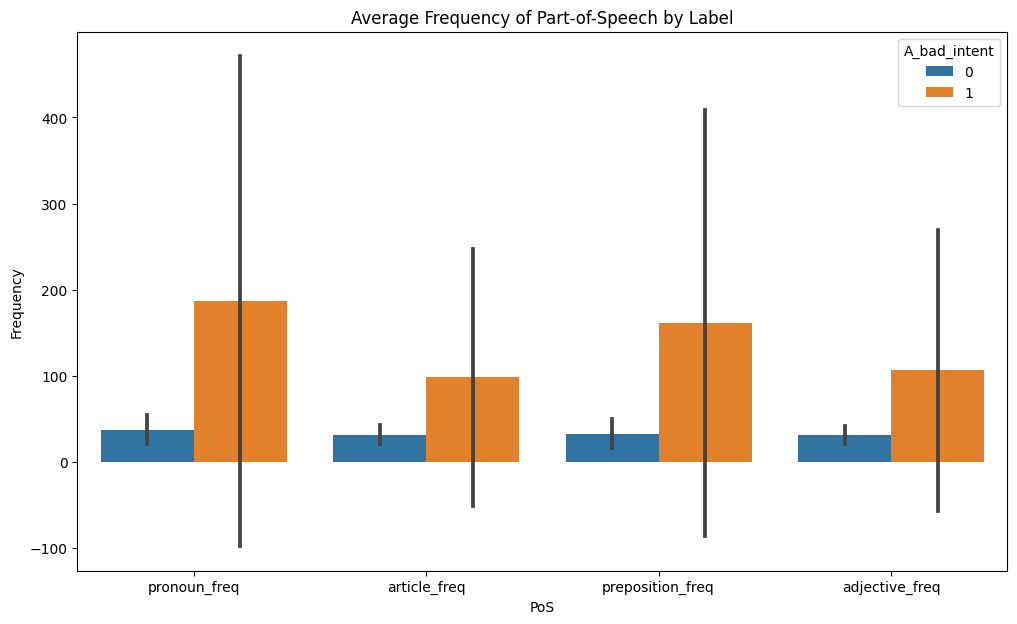

In [23]:
chart_df = pd.DataFrame()
chart_df['pronoun_freq'] = pron_freq
chart_df['article_freq'] = article_freq
chart_df['preposition_freq'] = prep_freq
chart_df['adjective_freq'] = adj_freq
chart_df['A_bad_intent'] = df['A_bad_intent']
chart_df['B_bad_intent'] = df['B_bad_intent']

df_melted = chart_df.melt(id_vars=['A_bad_intent' ,'B_bad_intent'], value_vars=['pronoun_freq', 'article_freq', 'preposition_freq', 'adjective_freq'], 
                    var_name='PoS', value_name='Frequency')

plt.figure(figsize=(12, 7))
sns.barplot(x='PoS', y='Frequency', hue='A_bad_intent', data=df_melted, ci='sd')
plt.title('Average Frequency of Part-of-Speech by Label')
plt.show()

In [24]:
num_samples = len(df)
# Calculate the average number of words per sample
num_words = df['conversation'].apply(lambda x: len(x.split()))
avg_words_per_sample = num_words.mean()

# Calculate the ratio
ratio = num_samples / avg_words_per_sample
ratio

2.381666193118093

---
### Preaper dataset for classification

<Axes: xlabel='A_bad_intent', ylabel='count'>

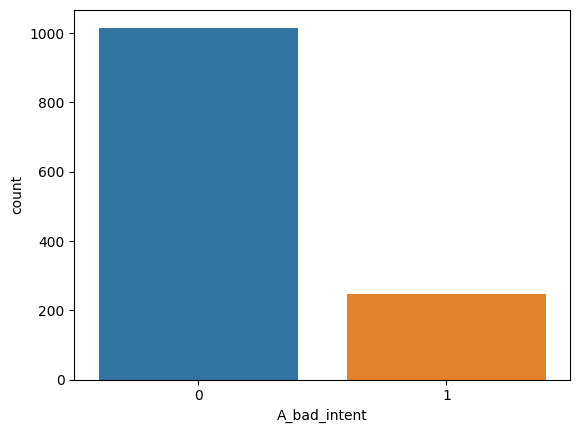

In [25]:
sns.countplot(data = df, x= df['A_bad_intent'])

#### balance the dataset or evalue the classification by weighted F1 score???

+ Normalization /scaling --> no need when using BERT
+ Shuffling --> shuffle=True in train_test_split


---
### Classification

In [26]:
class ConversationDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        # get a single conversation
        text = self.data[idx]['conversation']
        # tokenize that
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=False, # I manullay add [CLS] and [SEP] token
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt',
            truncation=True #  do we really need truncation?
        )
        #print(inputs.column_names)
        # add labels
        label_a = 1 if self.data[idx]['A_bad_intent'] == 1 else 0
        label_b = 1 if self.data[idx]['B_bad_intent'] == 1 else 0       
        
        return {
            'input_ids': inputs['input_ids'].squeeze(), # tokenized and encoded text, suitable for input to a BERT
            'attention_mask': inputs['attention_mask'].squeeze(), # mask indicating which parts of the input_ids are actual tokens and which are padding
            'A_bad_intent': label_a,
            'B_bad_intent': label_b
        }

In [27]:
#@todo use BertForSequenceClassification instead of BertModel?

class ParticipantClassifier(nn.Module):
    def __init__(self, bert_model_name):
        super(ParticipantClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        # add a linear layer that maps the hidden state to two outputs, labels
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
 
    # input_ids, attention_mask are ouputs of tokenizer
    def forward(self, input_ids, attention_mask):
        # pass the input to the model
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # [CLS] token representation
        logits = self.classifier(pooled_output)
        # models confidence score for each calss
        logits_a = logits[:, 0]
        logits_b = logits[:, 1]
        return logits_a, logits_b

To feed the text to BERT, first it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

In [28]:
#bert-base-uncased model has only lowercase letters!
# bert-base-cased: This model is case-sensitive: it makes a difference between english and English.
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False) 


In [29]:
#Train Test Validation split

# shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
 
# define split sizes
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))
 
# split the DataFrame
train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]
 

In [30]:
train_data = train_df.to_dict('records')
val_data = val_df.to_dict('records')
test_data = test_df.to_dict('records')
#data
# Get the lists of sentences and their labels.
#data = df.conversation.values
#labels = df.target.values

In [31]:
# Print the original conversation.
print(' Original: ', train_data[300])
# Print that split into tokens.
tokenized_sample = tokenizer.tokenize(train_data[300]['conversation'])
print('Tokenized: ', tokenized_sample)
# Print mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenized_sample))

 Original:  {'conversation': "[CLS]A:Good morning!  How are you today?[SEP]B:I'm starting to get my morning going. How about you>[SEP]A:Good so far!  Today I'm informing people about a charity called Save the Children.  Have you heard of them?[SEP]B:It sounds familiar, but I'm not sure.  It is a generic title.[SEP]A:They are a charity which promotes children's rights, provides relief and helps support children in developing countries[SEP]B:That sounds like a good charity.  I'm guessing that it is all international, and not local?[SEP]A:It's international.  They help all over the world![SEP]B:That is good.  I just know there are a lot of local children that need help.  How trustworthy are they?[SEP]A:They're very transparent with how they use their funding.  86% goes directly to their programs, 9% to fundraising, and the remaining 5% to management and general expenses [SEP]B:Those are good stats![SEP]A:Every day, 16,000 children die before their 5th birthday, mostly from preventable cau

In [32]:
# batch and suffle the data
train_dataset = ConversationDataset(train_data, tokenizer, max_length=512)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ConversationDataset(val_data, tokenizer, max_length=512)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

test_dataset = ConversationDataset(test_data, tokenizer, max_length=512)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [33]:
train_dataset[0]

{'input_ids': tensor([  101,   138,   131,  1731,  1277,  1156,  1128,  1176,  1106, 23969,
          1106,  1103,  3277,  1103,  1482,  1610,  1785,   102,   139,   131,
           146,  1156,  1176,  1106, 23969,   119,  1851,   117,   102,   138,
           131,  4514,  1128,  1115,   112,   188,  1304, 12839,  1104,  1128,
           102,   139,   131,  1135,   112,   188,  1136,  1112, 12839,  1112,
           146,   112,   173,  1176,   132,  1133,  1551,  1132,  8035,   119,
           102,   138,   131,  2814,   178,  1169, 15123,  1106,  1115,   102,
           139,   131,  1422,  2252,  3055,  8204,  1117,  4406,  2261,   119,
           102,   138,   131,  2048,  1110,  1115,  1363,  1137,  2213,   136,
           102,   139,   131,  1753,  1363,   132,  1115,  1108,  1539,   119,
          3135,   170,  2370,  1115,  1108,  4395,  1106,  2653,  1113, 10020,
           119,  1986,   146,  1138,  1106,  2222,  1106,  1294,  1122,  1146,
         13232,  1111,  9786,   119,   

In [34]:
# If there's a GPU available...
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

using the CPU


In [35]:
def compute_metrics(model, dataloader):
    model.eval()  # put model in evaluation mode
    device = next(model.parameters()).device  # get the device of the model
 
    true_labels_a = []
    true_labels_b = []
    pred_labels_a = []
    pred_labels_b = []
 
    with torch.no_grad():  # no need to track gradients for evaluation
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # Get model predictions
            logits_a, logits_b = model(input_ids, attention_mask)
            # Apply sigmoid to convert logits to probabilities
            probs_a = torch.sigmoid(logits_a).cpu().numpy()
            probs_b = torch.sigmoid(logits_b).cpu().numpy()
            # Convert probabilities to binary predictions
            preds_a = (probs_a > 0.5).astype(int)
            preds_b = (probs_b > 0.5).astype(int)
            # Collect true labels and predictions for later evaluation
            true_labels_a.extend(batch['A_bad_intent'].numpy())
            true_labels_b.extend(batch['B_bad_intent'].numpy())
            pred_labels_a.extend(preds_a)
            pred_labels_b.extend(preds_b)
 
    #
    #accuracy_a = accuracy_score(true_labels_a, pred_labels_a)
    #accuracy_b = accuracy_score(true_labels_b, pred_labels_b)
    # weighted f1 score becouse dataset is imbalanced
    f1_a = f1_score(true_labels_a, pred_labels_a, average='weighted')
    f1_b = f1_score(true_labels_b, pred_labels_b, average='weighted')
 
    return {
        'f1_a': f1_a,
        'f1_b': f1_b
    }

In [36]:
train_dataset.max_length

512

In [37]:
# Model & Optimizer
model = ParticipantClassifier('bert-base-cased')
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8) # eps: a very small number to prevent any division by zero
loss_function = nn.BCEWithLogitsLoss()

In [38]:
train_dataloader.batch_size

16

In [39]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:    
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:    
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [40]:
#@todo check oov words

In [41]:
#@todo handle 512 token limit

In [42]:
#@ improve metrics calculation

In [43]:
for epoch in range(1):  # 3 epochs?
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Labels need to be of float type and reshaped to be of the same size as output logits
        labels_a = batch['A_bad_intent'].to(device).float().view(-1, 1)
        labels_b = batch['B_bad_intent'].to(device).float().view(-1, 1)
        logits_a, logits_b = model(input_ids, attention_mask)
       
        # No need to apply sigmoid before using BCEWithLogitsLoss
        loss_a = loss_function(logits_a.view(-1, 1), labels_a)
        loss_b = loss_function(logits_b.view(-1, 1), labels_b)
        loss = (loss_a + loss_b) / 2
        loss.backward()
        optimizer.step()
    metrics = compute_metrics(model, test_dataloader)
    print(metrics)

{'f1_a': 0.9947139968699893, 'f1_b': 0.9947139968699893}
